## 8. Putting all together with multiclass classification problem 

* Binary classsclassification = one thing or another (Cat vs Dog) (Spam, not spam) (fraud, not fraud) 0 or 1
* Multiclass classification = more than one thing or anohter (chicken, dog, cat) could be 1000 things

#### 8.1 Creating a toy multi-class datas

In [5]:
# Import dependencies 
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

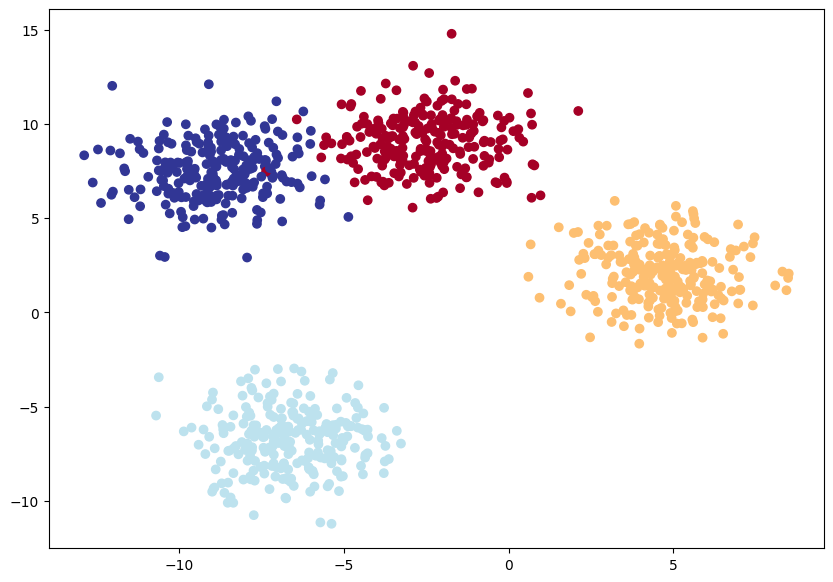

In [6]:



#Set hyperparmeters for data creating 
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEEDS = 42


# 1. Create multi class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5, #give the clusters a little shake up
                           random_state=RANDOM_SEEDS)

#2. Turn datat into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # to over come crossentropy loss type error for class indeces 

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state = RANDOM_SEEDS)


# 4. Plot the data (visualize, )
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


In [7]:
# define accuracy function
def accuracy_fn(y_true, y_pred):
    """
    Function to compute the accuracy
    
    Args: 
    ground_trouth_label, predicted_model output
    
    Return:
    accuracy : how model is correct compared to the true labels
    
    Example: 
    let's say y is ground truth, and y^ is the predicted labels
    if y = 100 and y^ that are equal to y is 84 item
    then: 
    the accucy would be : 84 / 100 * 100 = 0.84 or 84 %
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred) ) * 100 
    return acc

### 8.2 Building a multi class classification model in PyTorch

In [8]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# Build a multi class classification mdoel
class BlobModel(nn.Module): # upgrade class >> take inputs > set some parameters for the model >> 
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes mult-class classification model.
        
        Args: 
           input_features (int) : Number of input features to the model
           output_features (int) : Number of outputs features (number of output classes)
           hidden_units (int): Number of hidden units between layers, default 8
           
           Returns: 
           
           Examples:
           
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units ),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x): # as a linear layer stack sequentially -> the input will go throght all layers sequentially
        return self.linear_layer_stack(x)

# Create an instance of blob model
model_4 = BlobModel(input_features=2, 
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
X_blob_train.shape, y_blob_train.shape, torch.unique(y_blob_train)

(torch.Size([800, 2]), torch.Size([800]), tensor([0, 1, 2, 3]))

## 8.3 Create a loss function and an optimizer for a multi class classification model

Cross entropy loss / cost / criterion >> computes teh the cross entropy loss between input and target >>>

When training a classification problem with C class, we apply a weight .>>> if we have unbanced samples of those classes >>> unbalanced dataset .... using weigths ... 

Cross Enropy ...


In [11]:
# Create a loss function for multi class classification (meaures how wrong our model's predictions are)

loss_fn = nn.CrossEntropyLoss()

# Create optimizer (update our model parameters to try and reduce the loss)

optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1) # learning rate is a hyperparameter to change

### 8.4 Building a training loop ( Gettering prediction probability for a multicalss Model)

In [12]:
# Let's get some raw outputs of our model (logits)
next(model_4.parameters()).device, X_blob_test.device

(device(type='cuda', index=0), device(type='cpu'))

In [13]:
# evaluate the model -> before training 
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

In [14]:
y_logits.shape, y_blob_test.shape

(torch.Size([200, 4]), torch.Size([200]))

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels. 
Logits (raw outputs of the mdoel) -> pred Probs (use 'torch.softmax') -> Pred labels (take the 'argmax' of the model probabiliities 


In [15]:
# using a activation function (sigmoid for binary classification) and (softmax for multiclass classification)
# Convert our model's output logits ouput to prediction probabilities 

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:4]) 
print(y_pred_probs[:4])

tensor([[ 1.0885,  0.9800, -0.2470,  1.0178],
        [-1.1976, -0.8177, -0.5590,  0.9640],
        [ 0.4929,  0.2223,  0.3781, -1.9510],
        [ 1.2458,  1.0335, -0.0541,  0.3046]], device='cuda:0')
tensor([[0.3234, 0.2902, 0.0851, 0.3013],
        [0.0767, 0.1121, 0.1452, 0.6660],
        [0.3648, 0.2783, 0.3252, 0.0317],
        [0.4046, 0.3272, 0.1103, 0.1579]], device='cuda:0')


In [16]:
# replicate softmax by taking exp (x) / sum exp(x)
print("The total of soft max function summed to 1", torch.sum(y_pred_probs[0]))

The total of soft max function summed to 1 tensor(1., device='cuda:0')


In [17]:
print(" The model probabliity ", torch.max(y_pred_probs[1]))

 The model probabliity  tensor(0.6660, device='cuda:0')


In [18]:
print(" The right class/ predicted class ", torch.argmax(y_pred_probs[1]))

 The right class/ predicted class  tensor(3, device='cuda:0')


In [19]:
# Covert our model's prediction probablities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 3, 0, 0, 3, 3, 0, 3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0,
        0, 2, 3, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3,
        3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 2, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 0, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 0, 3, 3, 3,
        0, 3, 3, 2, 3, 3, 3, 3, 2, 3, 0, 3, 3, 0, 0, 0, 3, 0, 2, 3, 3, 3, 0, 2,
        2, 3, 3, 0, 0, 3, 3, 3, 2, 3, 0, 0, 3, 0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 2,
        0, 2, 3, 3, 3, 2, 0, 0, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 0, 3, 3, 0, 3,
        0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 2, 3, 0, 0, 2, 3, 3,
        0, 3, 2, 3, 3, 0, 2, 0], device='cuda:0')

In [20]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [21]:
loss_fn

CrossEntropyLoss()

In [22]:
accuracy_fn

<function __main__.accuracy_fn(y_true, y_pred)>

In [23]:
y_logits[:3], y_logits.shape, y_logits.dtype, y_blob_train[:3], y_blob_train.shape, y_blob_train.dtype

(tensor([[ 1.0885,  0.9800, -0.2470,  1.0178],
         [-1.1976, -0.8177, -0.5590,  0.9640],
         [ 0.4929,  0.2223,  0.3781, -1.9510]], device='cuda:0'),
 torch.Size([200, 4]),
 torch.float32,
 tensor([1, 0, 2]),
 torch.Size([800]),
 torch.int64)

## 8.5 Create the training loop and testing loop for a multi-class model

In [24]:
# Fit the multi-class model to the data 
#Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set number of epochs
epochs = 100

# put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#Loop through the data
for epoch in range(epochs):
    ### Training
    model_4.train()
    
    y_logits = model_4(X_blob_train) # raw outputs fo our model 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> pred probs -> pred labels
    
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                     y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    #Testing 
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                         y_pred=test_preds)
        
    #Print out what's hapenin
    if epoch % 10  ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test_loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}% ")



Epoch: 0 | Loss: 1.28504, Acc: 36.50% | Test_loss: 0.82750, Test_acc: 60.50% 
Epoch: 10 | Loss: 0.21941, Acc: 93.50% | Test_loss: 0.21503, Test_acc: 93.50% 
Epoch: 20 | Loss: 0.09642, Acc: 99.25% | Test_loss: 0.08896, Test_acc: 99.50% 
Epoch: 30 | Loss: 0.06682, Acc: 99.25% | Test_loss: 0.05961, Test_acc: 99.50% 
Epoch: 40 | Loss: 0.05308, Acc: 99.25% | Test_loss: 0.04580, Test_acc: 99.50% 
Epoch: 50 | Loss: 0.04537, Acc: 99.25% | Test_loss: 0.03787, Test_acc: 99.50% 
Epoch: 60 | Loss: 0.04052, Acc: 99.25% | Test_loss: 0.03278, Test_acc: 99.50% 
Epoch: 70 | Loss: 0.03724, Acc: 99.25% | Test_loss: 0.02928, Test_acc: 99.50% 
Epoch: 80 | Loss: 0.03488, Acc: 99.25% | Test_loss: 0.02672, Test_acc: 99.50% 
Epoch: 90 | Loss: 0.03313, Acc: 99.25% | Test_loss: 0.02478, Test_acc: 99.50% 


### 8.6 Making and evaluating predicitons with model

In [25]:
# Making predicitons and evaluating our multi-class classifiction model

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    
# View the first 10 predictions 
y_logits[:10]


tensor([[  9.7100,  14.7208,  -6.6725,  -3.3163],
        [  1.0471, -12.6499,  -2.3301,   6.3479],
        [-14.9977, -16.8722,  11.4372,   2.4601],
        [  4.8588,  10.6689,  -2.8518,  -3.1907],
        [ 12.1191,   6.9549,  -9.7744,   1.2056],
        [  0.6232, -16.0943,  -2.3770,   7.8078],
        [-14.2012, -13.0889,  11.1939,   0.9776],
        [  8.9172,   1.7273,  -7.5672,   2.4855],
        [-17.2671, -23.3349,  12.6619,   4.6601],
        [  9.9036,   3.6061,  -8.2141,   1.9654]], device='cuda:0')

In [26]:
# Go from logits -> Prediction probibilities (using softmax with multiclass labels )
y_pred_probs = torch.softmax(y_logits, dim=1) # one closest to 1, its index would be our index class 
y_pred_probs[:10]

tensor([[6.6215e-03, 9.9338e-01, 5.0833e-10, 1.4578e-08],
        [4.9615e-03, 5.5863e-09, 1.6941e-04, 9.9487e-01],
        [3.3071e-12, 5.0738e-13, 9.9987e-01, 1.2626e-04],
        [2.9884e-03, 9.9701e-01, 1.3389e-06, 9.5406e-07],
        [9.9430e-01, 5.6851e-03, 3.0854e-10, 1.8106e-05],
        [7.5758e-04, 4.1601e-11, 3.7708e-05, 9.9920e-01],
        [9.3548e-12, 2.8450e-11, 9.9996e-01, 3.6567e-05],
        [9.9764e-01, 7.5238e-04, 6.9168e-08, 1.6059e-03],
        [1.0042e-13, 2.3261e-16, 9.9967e-01, 3.3474e-04],
        [9.9781e-01, 1.8368e-03, 1.3508e-08, 3.5605e-04]], device='cuda:0')

In [27]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [28]:
# Go from pred probs to pred labels 
#y_pred_probs.argmax()
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10] # compared to y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

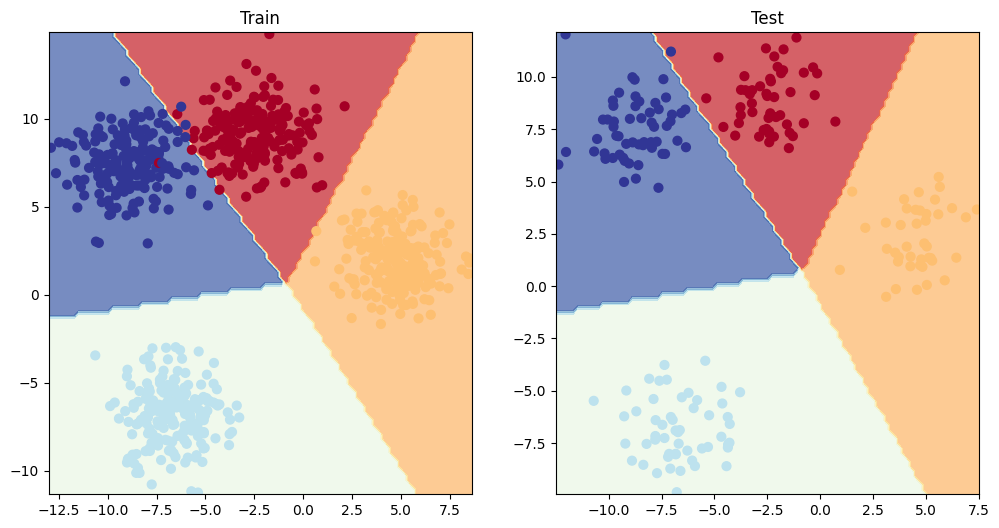

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.savefig("/home/mhamdan/DeepLearning_PyTorch_2022/output/Model_4_with_no_non_linearity.png")

# 9. A few more classification metrics (to evaluate model)

* A ccuracy out of 100 samples how many of them are correct

* Precision 
* Recall
* F1-score
* Classification matrix
* Classification report

* Accuracy = tp + tn / tp + fp + fn 
* accuracy = torchmetrics.Accuracy() or sklearn.metrics.accuracy_score() 
* accuracy used as default for classification problems. But not ideal when we have an imbalanced classes.

#----- 

* Precision = tp / tp + fp 
* precision = torchmetrics.Precision() or sklearn.metrics.precision_score() 
* Precision used where higher precision leads to less false positives. if false positives are not ideal, increase Precision

#----- 

* Recall = tp / tp + fn 
* Recall = torchmetrics.Recall() or sklearn.metrics.recall_score() 
* Recall used where higher recall leads to less false negative. if false negatives are not ideal, increase recall



#----- 

* F1_score = precision * recall / precision + recall
* F1_score = torchmetrics.F1_score() or sklearn.metrics.f1_score() 
* F1_Score comination of precision and recall, usually a good overall metric for a classification mdoe. 


#----- 

* Confusion matrix = NA
*  Confusion matrix = torchmetrics.ConfusionMatrix() or sklearn.metrics.confusionmatrix() 
*  Confusion matrix : when comparing predictions to truth labels to see where models gets confused. Can be hard to use with large numbers of classes. 

#----
* torchmetrics ... PyTorch like code
* Classification report >> combined all above metrics .......

In [30]:
import torchmetrics
from torchmetrics import Accuracy

In [32]:
# Set up metric
torchmetric_accuracy = Accuracy().to(device)

# Calcualte the accuracy 
torchmetric_accuracy (y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [36]:
from torchmetrics import Precision 
torchmetric_precision = Precision().to(device)
torchmetric_precision(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [37]:
from torchmetrics import Recall 
torchmetric_recall = Recall().to(device)
torchmetric_recall(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [38]:
from torchmetrics import F1Score 
torchmetric_f1score = F1Score().to(device)
torchmetric_f1score(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [40]:
from torchmetrics import ConfusionMatrix 
torchmetric_CF = ConfusionMatrix(4).to(device)
torchmetric_CF(y_preds, y_blob_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]], device='cuda:0')